# 多层神经网络

本节在前面学习线性回归模型的基础上，我们学习如何利用PyTorch实现多层神经网络。

## 1. 多层神经网络
在前面的线性回归中，我们的公式是 $y = w x + b$，而在 Logistic 回归中，我们的公式是 $y = Sigmoid(w x + b)$，其实它们都可以看成单层神经网络，其中 Sigmoid 被称为激活函数。

### 1.1 神经网络的结构
神经网络就是很多个神经元堆在一起形成一层神经网络，那么多个层堆叠在一起就是深层神经网络

![nn demo](imgs/nn-forward.gif)

可以看到，神经网络的结构其实非常简单，主要有输入层，隐藏层，输出层构成，输入层需要根据特征数目来决定，输出层根据解决的问题来决定，那么隐藏层的网路层数以及每层的神经元数就是可以调节的参数，而不同的层数和每层的参数对模型的影响非常大，我们看看这个网站的示例 [demo](http://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html)

神经网络向前传播也非常简单，就是一层一层不断做运算即可。

### 1.2 示例程序

In [1]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

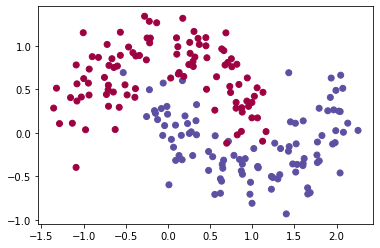

In [2]:
from sklearn import datasets

# generate sample data
np.random.seed(0)
data_x, data_y = datasets.make_moons(200, noise=0.20)

# plot data
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, cmap=plt.cm.Spectral)
plt.show()

In [3]:
def plot_decision_boundary(model, x, y):
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid .c_按行连接两个矩阵，左右相加。
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=40, cmap=plt.cm.Spectral)

这次我们仍然处理一个二分类问题，但是比前面的 logistic 回归更加复杂。我们可以先尝试用 logistic 回归来解决这个问题

In [4]:
# 变量
x = torch.from_numpy(data_x).float()
y = torch.from_numpy(data_y).float().unsqueeze(1)

# 定义参数
w = nn.Parameter(torch.randn(2, 1))
b = nn.Parameter(torch.zeros(1))

# 优化器
optimizer = torch.optim.SGD([w, b], 1e-1)

def logistic_regression(x):
    return torch.mm(x, w) + b
    
criterion = nn.BCEWithLogitsLoss()

In [5]:
for e in range(100):
    #更新并自动计算
    out = logistic_regression(Variable(x))
    loss = criterion(out, Variable(y))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 20 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.item()))

epoch: 20, loss: 0.6910861730575562
epoch: 40, loss: 0.5803939700126648
epoch: 60, loss: 0.5160364508628845
epoch: 80, loss: 0.4751732349395752
epoch: 100, loss: 0.44716107845306396


In [6]:
def plot_logistic(x):
    x = Variable(torch.from_numpy(x).float())
    out = F.sigmoid(logistic_regression(x))
    out = (out > 0.5) * 1
    return out.data.numpy()

/home/bushuhui/anaconda3/envs/dl/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5, 1.0, 'logistic regression')

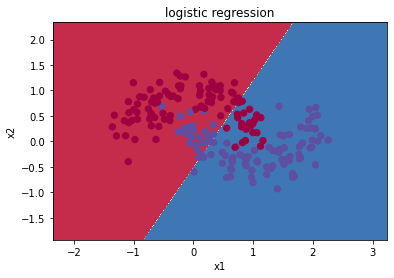

In [7]:
plot_decision_boundary(lambda x: plot_logistic(x), x.numpy(), y.numpy())
plt.title('logistic regression')

### 1.3 多层神经网络示例程序

可以看到，logistic 回归并不能很好的区分开这个复杂的数据集，如果你还记得前面的内容，你就知道 logistic 回归是一个线性分类器。接下来我们用两层神经网络来对同样的数据进行处理，看看效果如何。

In [8]:
# 定义两层神经网络的参数
w1 = nn.Parameter(torch.randn(2, 4) * 0.01) # 隐藏层神经元个数 2
b1 = nn.Parameter(torch.zeros(4))

w2 = nn.Parameter(torch.randn(4, 1) * 0.01)
b2 = nn.Parameter(torch.zeros(1))

# 定义模型
def two_network(x):
    x1 = torch.mm(x, w1) + b1
    x1 = torch.tanh(x1) # 使用 PyTorch 自带的 tanh 激活函数
    x2 = torch.mm(x1, w2) + b2
    return x2

optimizer = torch.optim.SGD([w1, w2, b1, b2], 1.)

criterion = nn.BCEWithLogitsLoss()

In [9]:
# 我们训练 1000 次
for e in range(1000):
    out = two_network(Variable(x))
    loss = criterion(out, Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.item()))

/home/bushuhui/anaconda3/envs/dl/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: 100, loss: 0.30548951029777527
epoch: 200, loss: 0.3037661612033844
epoch: 300, loss: 0.30283141136169434
epoch: 400, loss: 0.30222681164741516
epoch: 500, loss: 0.3017694056034088
epoch: 600, loss: 0.30137133598327637
epoch: 700, loss: 0.3009776175022125
epoch: 800, loss: 0.30053412914276123
epoch: 900, loss: 0.2999470829963684
epoch: 1000, loss: 0.29893115162849426


In [10]:
def plot_network(x):
    x = Variable(torch.from_numpy(x).float())
    x1 = torch.mm(x, w1) + b1
    x1 = F.tanh(x1)
    x2 = torch.mm(x1, w2) + b2
    out = F.sigmoid(x2)
    out = (out > 0.5) * 1
    return out.data.numpy()

Text(0.5, 1.0, '2 layer network')

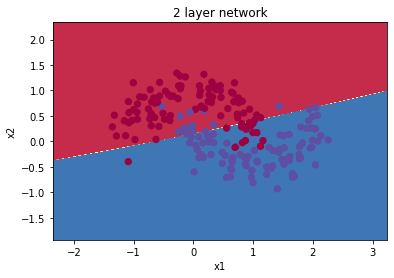

In [11]:
plot_decision_boundary(lambda x: plot_network(x), x.numpy(), y.numpy())
plt.title('2 layer network')

可以看到神经网络能够非常好地分类这个复杂的数据，和前面的 logistic 回归相比，神经网络因为有了激活函数的存在，成了一个非线性分类器，所以神经网络分类的边界更加复杂。

## 2. Sequential 和 Module

前面讲了数据处理，模型构建，loss 函数设计等等内容，但是目前为止我们还没有准备好构建一个完整的机器学习系统，一个完整的机器学习系统需要我们不断地读写模型。在现实应用中，一般我们会将模型在本地进行训练，然后保存模型，接着我们会将模型部署到不同的地方进行应用。


对于前面的线性回归模型、 Logistic回归模型和神经网络，在构建的时候定义了需要的参数。这对于比较小的模型是可行的，但是对于大的模型，比如100 层的神经网络，这个时候再去手动定义参数就显得非常麻烦，所以 PyTorch 提供了两个模块来帮助我们构建模型，一个是Sequential，一个是 Module。

Sequential 允许我们构建序列化的模块，而 Module 是一种更加灵活的模型定义方式，我们下面分别用 Sequential 和 Module 来定义上面的神经网络。

### 2.1 Sequential

In [12]:
# Sequential
seq_net = nn.Sequential(
    nn.Linear(2, 4), # PyTorch 中的线性层，wx + b
    nn.Tanh(),
    nn.Linear(4, 1)
)

In [13]:
# 序列模块可以通过索引访问每一层

seq_net[0] # 第一层

Linear(in_features=2, out_features=4, bias=True)

In [14]:
# 打印出第一层的权重

w0 = seq_net[0].weight
print(w0)

Parameter containing:
tensor([[-0.6391, -0.3023],
        [ 0.4236, -0.2388],
        [ 0.1976, -0.0334],
        [ 0.5111,  0.4610]], requires_grad=True)


In [15]:
# 通过 parameters 可以取得模型的参数
param = seq_net.parameters()

# 定义优化器
optim = torch.optim.SGD(param, 1.)

In [16]:
# 我们训练 10000 次
for e in range(10000):
    out = seq_net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.item()))

epoch: 1000, loss: 0.07238173484802246
epoch: 2000, loss: 0.06331096589565277
epoch: 3000, loss: 0.059657540172338486
epoch: 4000, loss: 0.057460710406303406
epoch: 5000, loss: 0.055878859013319016
epoch: 6000, loss: 0.05458137020468712
epoch: 7000, loss: 0.053432758897542953
epoch: 8000, loss: 0.05238530784845352
epoch: 9000, loss: 0.051434148102998734
epoch: 10000, loss: 0.05058830603957176


可以看到，训练 10000 次 loss 比之前的更低，这是因为 PyTorch 自带的模块比我们写的更加稳定，同时也有一些初始化的问题在里面，关于参数初始化，我们会在后面的课程中讲到

In [17]:
def plot_seq(x):
    out = F.sigmoid(seq_net(Variable(torch.from_numpy(x).float()))).data.numpy()
    out = (out > 0.5) * 1
    return out

Text(0.5, 1.0, 'sequential')

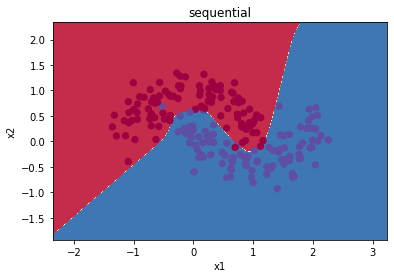

In [18]:
plot_decision_boundary(lambda x: plot_seq(x), x.numpy(), y.numpy())
plt.title('sequential')

### 2.2 保存模型参数

保存模型在 PyTorch 中有两种方式，一种是将模型结构和参数都保存在一起，一种是只将参数保存下来。

In [19]:
# 将参数和模型保存在一起
torch.save(seq_net, 'save_seq_net.pth')

上面就是保存模型的方式，`torch.save`里面有两个参数，第一个是要保存的模型，第二个参数是保存的路径，读取模型的方式也非常简单

In [20]:
# 读取保存的模型
seq_net1 = torch.load('save_seq_net.pth')

In [21]:
seq_net1

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [22]:
print(seq_net1[0].weight)

Parameter containing:
tensor([[-5.7823,  5.7006],
        [ 5.3129,  3.6949],
        [ 3.5471, -0.7431],
        [ 2.4003,  1.7605]], requires_grad=True)


我们可以看到我们重新读入了模型，并且将其命名为 seq_net1，并且打印了第一层的参数

下面我们看看第二种保存模型的方式，只保存参数而不保存模型结构

In [23]:
# 保存模型参数
torch.save(seq_net.state_dict(), 'save_seq_net_params.pth')

通过上面的方式，我们保存了模型的参数，如果要重新读入模型的参数，首先我们需要重新定义一次模型，接着重新读入参数

In [24]:
seq_net2 = nn.Sequential(
    nn.Linear(2, 4),
    nn.Tanh(),
    nn.Linear(4, 1)
)

seq_net2.load_state_dict(torch.load('save_seq_net_params.pth'))

<All keys matched successfully>

In [25]:
seq_net2

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [26]:
print(seq_net2[0].weight)

Parameter containing:
tensor([[-5.7823,  5.7006],
        [ 5.3129,  3.6949],
        [ 3.5471, -0.7431],
        [ 2.4003,  1.7605]], requires_grad=True)


通过这种方式我们也重新读入了相同的模型，打印第一层的参数对比，发现和前面的办法是一样

有这两种保存和读取模型的方法，我们推荐使用**第二种**，因为第二种可移植性更强

### 2.3 Module
下面我们再用 Module 定义这个模型，下面是使用 Module 的模板

```
class 网络名字(nn.Module):
    def __init__(self, 一些定义的参数):
        super(网络名字, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        self.layer2 = nn.Sequential(...)
        ...
        
        定义需要用的网络层
        
    def forward(self, x): # 定义前向传播
        x1 = self.layer1(x)
        x2 = self.layer2(x)
        x = x1 + x2
        ...
        return x
```

注意的是，Module 里面也可以使用 Sequential，同时 Module 非常灵活，具体体现在 forward 中，如何复杂的操作都能直观的在 forward 里面执行

下面我们照着模板实现一下上面的神经网络

In [27]:
class module_net(nn.Module):
    def __init__(self, num_input, num_hidden, num_output):
        super(module_net, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        
        self.layer2 = nn.Tanh()
        
        self.layer3 = nn.Linear(num_hidden, num_output)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [28]:
mo_net = module_net(2, 4, 1)

In [29]:
# 访问模型中的某层可以直接通过名字

# 第一层
l1 = mo_net.layer1
print(l1)

Linear(in_features=2, out_features=4, bias=True)


In [30]:
# 打印出第一层的权重
print(l1.weight)

Parameter containing:
tensor([[-0.0458, -0.6043],
        [ 0.0567, -0.6961],
        [ 0.5034,  0.2557],
        [ 0.2466, -0.5245]], requires_grad=True)


In [31]:
# 定义优化器
optim = torch.optim.SGD(mo_net.parameters(), 1.)

In [32]:
# 我们训练 10000 次
for e in range(10000):
    out = mo_net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.item()))

epoch: 1000, loss: 0.07277397811412811
epoch: 2000, loss: 0.06705372780561447
epoch: 3000, loss: 0.06257135421037674
epoch: 4000, loss: 0.056195128709077835
epoch: 5000, loss: 0.050691165030002594
epoch: 6000, loss: 0.04715902358293533
epoch: 7000, loss: 0.0447952002286911
epoch: 8000, loss: 0.04309132695198059
epoch: 9000, loss: 0.04179977998137474
epoch: 10000, loss: 0.040784407407045364


In [33]:
# 保存模型
torch.save(mo_net.state_dict(), 'module_net.pth')

可以看到我们得到了相同的结果，而且使用 Sequential 和 Module 来定义模型更加方便

在这一节中我们还是使用梯度下降法来优化参数，在神经网络中，这种优化方法有一个特别的名字，反向传播算法，下一次课我们会讲一讲什么是反向传播算法

**小练习：改变网络的隐藏层神经元数目，或者试试定义一个 5 层甚至更深的模型，增加训练次数，改变学习率，看看结果会怎么样**

下面举个例子

In [34]:
net = nn.Sequential(
    nn.Linear(2, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, 1)
)

optim = torch.optim.SGD(net.parameters(), 0.1)

In [35]:
# 我们训练 20000 次
for e in range(20000):
    out = net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.item()))

epoch: 1000, loss: 0.07510872185230255
epoch: 2000, loss: 0.0662045031785965
epoch: 3000, loss: 0.062202777713537216
epoch: 4000, loss: 0.053606368601322174
epoch: 5000, loss: 0.047997504472732544
epoch: 6000, loss: 0.045905228704214096
epoch: 7000, loss: 0.044531650841236115
epoch: 8000, loss: 0.04245807230472565
epoch: 9000, loss: 0.0403163880109787
epoch: 10000, loss: 0.03822056204080582
epoch: 11000, loss: 0.03605899214744568
epoch: 12000, loss: 0.033822499215602875
epoch: 13000, loss: 0.031671419739723206
epoch: 14000, loss: 0.029688959941267967
epoch: 15000, loss: 0.02786232717335224
epoch: 16000, loss: 0.026174388825893402
epoch: 17000, loss: 0.024574236944317818
epoch: 18000, loss: 0.022980017587542534
epoch: 19000, loss: 0.021339748054742813
epoch: 20000, loss: 0.019654229283332825


Text(0.5, 1.0, 'sequential')

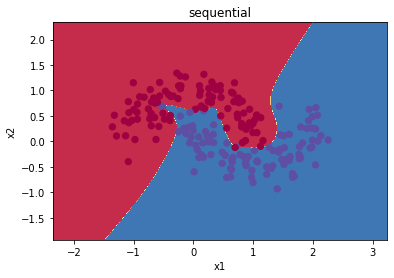

In [36]:
def plot_net(x):
    out = F.sigmoid(net(Variable(torch.from_numpy(x).float()))).data.numpy()
    out = (out > 0.5) * 1
    return out

plot_decision_boundary(lambda x: plot_net(x), x.numpy(), y.numpy())
plt.title('sequential')